# Network Analysis
### The next section contains the network analysis of the Stack Overflow data. 
The network will be modeled as a directed, weighted graph, in which each node is a unique user on Stack Overflow, and each edge is an interaction between a pair of users. The associated weight is the number of times these users have interacted.

#### The following steps are taken in this part of the Stack Overflow investigation:

1. Create individual networks for each programming language with authors as nodes and interactions (answering questions or commenting answers) as links.

2. Create one big Stack Overflow graph including all 16 programming languages with same types of nodes and links.

3. Perform basic network analysis (counts, degree distribution etc.) on language-specific networks and the Stack Overflow network. Comment on these results.

4. Vizualize the StackOverflow-network.

5. Perform advanced network analysis on the StackOverflow-network by investigating the different subnetworks, communities, modularity etc.

6. Use the Louvain algorithm to create a network from the data and compare to the StackOverflow-network.
 

In [3]:
### Imports
import os
import pandas as pd
import numpy as np
import networkx as nx
import netwulf as nf
import community as cm
from scipy import stats 
from operator import itemgetter 
from collections import Counter
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

loved_languages = {
    "rust":        86.1,
    "typescript":  67.1,
    "python":      66.7,
    "kotlin":      62.9,
    "go":          62.3,
    "dart":        62.1,
    "c#":          59.7,
    "javascript":  58.3,
    "haskell":     51.7,
    "java":        44.1,
    "c++":         43.4,
    "ruby":        42.9,
    "c":           33.1,
    "perl":        28.6,
    "objective-c": 23.4,
    "vba":         19.6,
}
language_colors = {
    "rust":        'peru',
    "typescript":  'navy',
    "python":      'cyan',
    "kotlin":      'azure',
    "go":          'grey',
    "dart":        'maroon',
    "c#":          'purple',
    "javascript":  'yellow',
    "haskell":     'black',
    "java":        'green',
    "c++":         'red',
    "ruby":        'olive',
    "c":           'pink',
    "perl":        'magenta',
    "objective-c": 'lime',
    "vba":         'orange',
}

# data = pd.read_pickle('/home/augustsemrau/drive/6semester/CSS_02467/css-project/data_old.pkl')

In [6]:
data

,language,owner/reputation,creation_date,title,view_count,question_id,owner/user_id,link,score,body,type,answer_id,clean
2304563,perl,78982,1549112278,NaN,NaN,54492860,1848654,NaN,0,Don&#39;t interpolate variables into your SQL....,c,NaN,don39 interpolate variables sql use placehol...
2268267,perl,50468,1490779614,NaN,NaN,43088228,1331451,NaN,0,I&#39;ve written an answer with a little guide...,c,NaN,i39 written answer little guide get star...
1801510,c++,45,1472656513,NaN,NaN,39251944,6779143,NaN,0,"@πάνταῥεῖ nope, 938e008 for example",c,NaN,nope 938e008 example
569555,javascript,456,1438826613,NaN,NaN,31842757,3158139,NaN,-1,<p>In situations like that I've found its easi...,a,31845658,in situations like i found easiest try \n\n...
955901,typescript,405,1489097404,NaN,NaN,42660902,4526050,NaN,0,Trying to follow your steps. Where exactly do ...,c,42692195,trying follow steps where exactly add l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153557,javascript,111,1481754287,How should i display number in HTML for later ...,893,41153295,7298415,https://stackoverflow.com/questions/41153295/h...,1,<p>I am trying to figure out how to display nu...,q,NaN,i trying figure display number right ef...
1340205,c#,870,1459983781,NaN,NaN,36462658,4522501,NaN,0,For some reason I had to add like 10 spaces to...,c,36462970,for reason i add like 10 spaces work sure...
1196503,go,38332,1515179422,NaN,NaN,36458649,763585,NaN,1,@MrMesees I wouldn&#39;t necessarily say it&#3...,c,36458716,mrmesees i 39 necessarily say 39 dangerous 39 ...
1503284,javascript,796419,1522875016,NaN,NaN,49659975,34397,NaN,0,What response do you see in the Network Tab?,c,NaN,what response see network tab


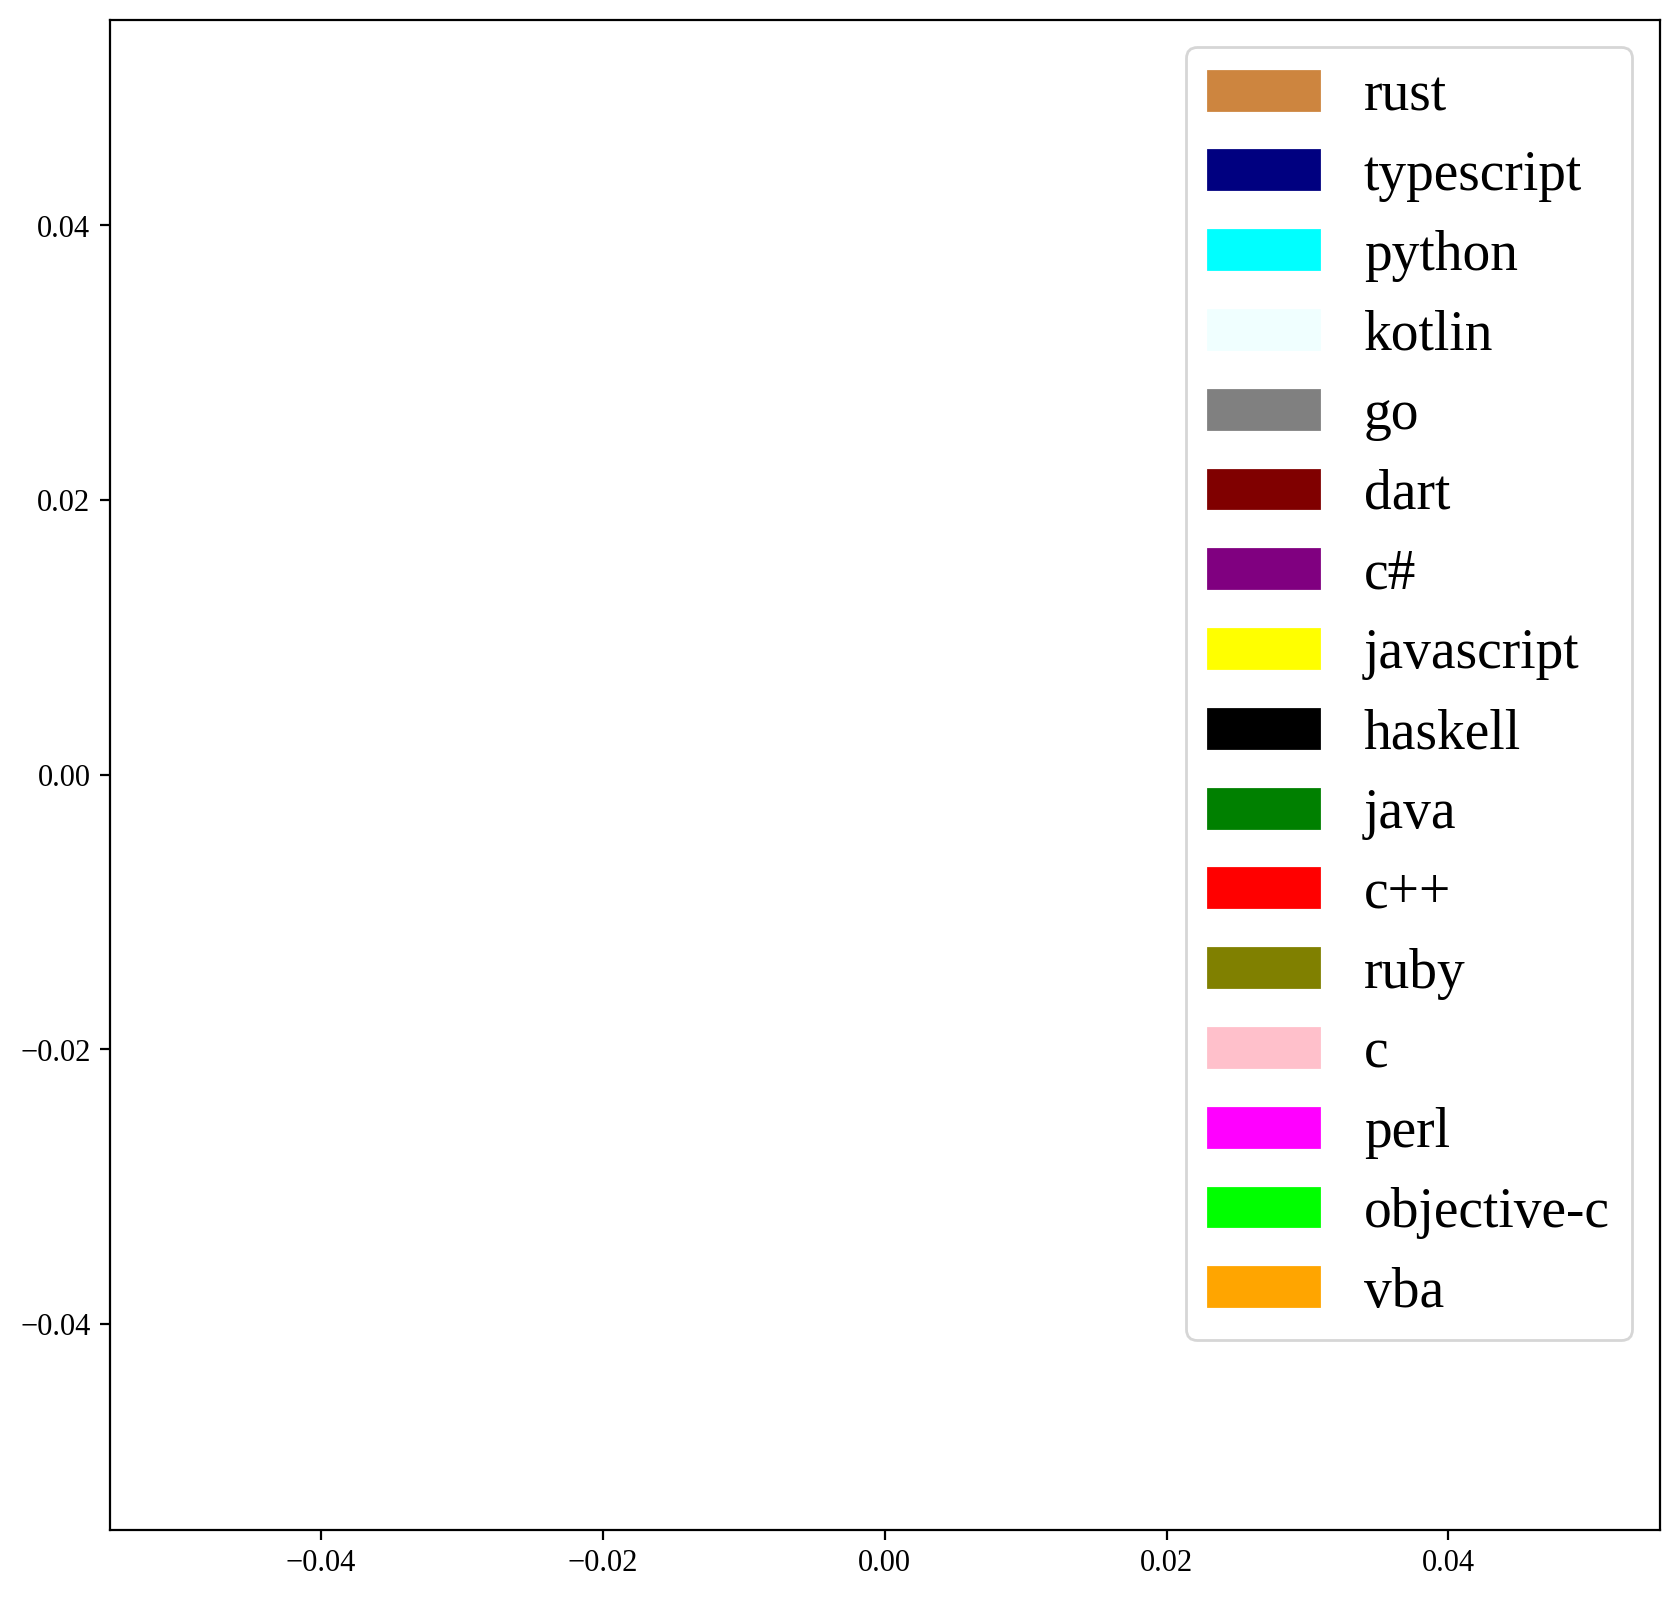

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (10,10)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

patches = []
fig, ax = plt.subplots()
for prog_lang in language_colors.keys():
    ax.plot(0, 0,  label=prog_lang, color = language_colors[prog_lang])
    patches.append(mpatches.Patch(color=language_colors[prog_lang], label=prog_lang))

# ax.legend(loc='upper right', prop={'size': 20})
ax.legend(loc='upper right', handles=patches,prop={'size': 20})

## 2. Create one big StackOverflow-network including all 16 programming languages with same types of nodes and links.

In [2]:
### Function for creating one big Stack-Overflow network graph
def so_network(so_data, directed=True):

    ## Get Questions, answers and comments seperately
    questions = so_data.loc[so_data['type'] == 'q']
    answers = so_data.loc[so_data['type'] == 'a']
    comments = so_data.loc[so_data['type'] == 'c']
    print(questions.shape)
    print(answers.shape)
    print(comments.shape)

    ## Get authors of questions and answers
    question_authors = dict(zip(questions['question_id'], questions['owner/user_id']))
    answer_authors = dict(zip(answers['answer_id'], answers['owner/user_id']))

    ## Find parent id's of all datapoints
    so_data['parent_author'] = ""
    for index, row in tqdm(so_data.iterrows()):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            row['parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                row['parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                row['parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                row['parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    row['parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    row['parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print('Stack Overflow data before filtering for NANs', so_data.shape)
    so_data = so_data[so_data['parent_author'].notnull()]
    so_data = so_data[so_data['owner/user_id'].notnull()]
    so_data = so_data[so_data['parent_author'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != 'None']
    print(so_data[so_data['parent_author'] == ''].shape)
    print(so_data[so_data['owner/user_id'] == ''].shape)
    so_data = so_data[so_data['owner/user_id'] != so_data['parent_author']]
    print('Stack Overflow data after filtering for NANs', so_data.shape)

    ## Create weighted edge list for all sets of source, target and programming language
    edge_list = so_data.groupby(['owner/user_id', 'parent_author', 'language']).size().to_frame('weight').reset_index()

    ## Make language and weight info-dict
    edge_list['language_weight'] = edge_list.apply(lambda row: {row['language']:row['weight']}, axis=1)

    print('Edge list before accomodating for bilingual source-target pairs', edge_list.shape)

    ## Find duplicates, ie. source-target pairs interacting on 2 or more different prog. languages
    bilinguals = edge_list[edge_list.duplicated(['owner/user_id', 'parent_author'], keep=False)]
    bilinguals_last = bilinguals[bilinguals.duplicated(['owner/user_id', 'parent_author'], keep='first')]

    ## Drop duplicates keeping first instance
    edge_list = edge_list.drop_duplicates(['owner/user_id', 'parent_author'], keep='first')

    ## Add the duplicates' language-weight data to the first instance of the interaction
    for _, row in tqdm(bilinguals_last.iterrows()):
        index = edge_list.index[(edge_list['owner/user_id'] == row['owner/user_id']) & (edge_list['parent_author'] == row['parent_author'])]
        edge_list.loc[index]['language_weight'].item()[row['language']] = row['weight']

    print('Edge list after accomodating for bilingual interaction pairs', edge_list.shape)
    
    # edge_list = edge_list[edge_list]

    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])
    language_weights = list(edge_list['language_weight'])
    
    ## Create graph, adding nodes and edges
    if directed:
        so_graph = nx.DiGraph()
    else:
        so_graph = nx.Graph()
        
    for i in tqdm(range(len(sources))):

        ## If node not already in graph, we add it, otherwise we add the language weights
        if sources[i] not in so_graph:
            so_graph.add_node(sources[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[sources[i]]['languages']:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])
        
        if targets[i] not in so_graph:
            so_graph.add_node(targets[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[targets[i]]['languages']:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])

        so_graph.add_edge(sources[i], targets[i])#, weight=sum(language_weights[i].values()))

    ## Add  top language as node attribute
    for i in so_graph:
        top_lang = sorted(so_graph.nodes[i]['languages'], key=so_graph.nodes[i]['languages'].get)[-1]
        so_graph.nodes[i]['top_language'] = top_lang
        so_graph.nodes[i]['color'] = language_colors[so_graph.nodes[i]['top_language']]

    return so_graph

In [3]:
### This cell creates the Stack Overflow graph and saves a pickle
so_graph = so_network(so_data=data, directed=True)
## Save to pickle for later use
path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
nx.write_gpickle(so_graph, path)

so_undirected_graph = so_network(so_data=data, directed=False)
## Save to pickle for later use
path = os.getcwd() + '/graphs/' + 'so_undirected_graph.pkl'
nx.write_gpickle(so_undirected_graph, path)

0it [00:00, ?it/s](182895, 13)
(252543, 13)
(834449, 13)
1269887it [01:42, 12406.77it/s]
Stack Overflow data before filtering for NANs (1269887, 14)
(0, 14)
(0, 14)
Stack Overflow data after filtering for NANs (442372, 14)
Edge list before accomodating for bilingual source-target pairs (355329, 5)
10it [00:00, 11.18it/s]


KeyboardInterrupt: 

## 3. Perform basic network analysis (counts, degree distribution etc.) on language-specific networks and the Stack Overflow network. Comment on these results.

In [6]:
### This cell loads the Stack Overflow network graph and creates subgraphs based on the top prgoramming language partitioning

## Stack Overflow graph
so_graph_path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
so_graph = nx.read_gpickle(so_graph_path)

## Retrieve the 16 different programming languages as partitions
so_partitions = {prog_lang : [i for i in so_graph if so_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}
# for prog_lang in loved_languages.keys():
#     print(f"{len(so_partitions[prog_lang])} nodes belong to {prog_lang}")

## Now these are all gathered in a dict
graphs = {prog_lang : None for prog_lang in loved_languages.keys()}

for prog_lang in tqdm(graphs.keys()):
    # prog_lang_graph_path = os.getcwd() + '/graphs/' + str(prog_lang) + '_graph.pkl'
    # graphs[prog_lang] = nx.read_gpickle(prog_lang_graph_path)
    graphs[prog_lang] = so_graph.subgraph(so_partitions[prog_lang])

graphs['stack_overflow'] = so_graph

100%|██████████| 16/16 [00:00<00:00, 235.91it/s]


In [7]:
### This cell contains function for retrieving basic analysis metrics

## Number of nodes, number of links and density of graph
def basic_graph_analysis(graph):
    num_nodes = graph.number_of_nodes()
    num_links = graph.number_of_edges()
    density = nx.classes.function.density(graph)
    return num_nodes, num_links, round(density, 7)

## In and Out-degrees
def graph_degrees(graph):
    in_degrees = list(dict(graph.in_degree()).values())
    out_degrees = list(dict(graph.out_degree()).values())
    return in_degrees, out_degrees

In [8]:
### Graphs basic summary
t = Table()
t.add_row(["Language", "Num Nodes", "Num Links", "Density"])
for prog_lang in graphs.keys():
    num_nodes, num_links, density = basic_graph_analysis(graph=graphs[str(prog_lang)])
    t.add_row([prog_lang.capitalize(), num_nodes, num_links, density], [1, 0, 0, 0])

print("Basic statistics of programming language graphs")
print(t)

Basic statistics of programming language graphs
Language       | Num Nodes | Num Links | Density  
Rust           |      3979 |      8567 | 0.0005412
Typescript     |     15115 |     16753 |  7.33e-05
Python         |     17336 |     18555 |  6.17e-05
Kotlin         |      9209 |     12058 | 0.0001422
Go             |     11054 |     18011 | 0.0001474
Dart           |      6528 |      9773 | 0.0002294
C#             |     17007 |     20121 |  6.96e-05
Javascript     |     18344 |     17955 |  5.34e-05
Haskell        |      6099 |     19016 | 0.0005113
Java           |     17359 |     17393 |  5.77e-05
C++            |     14757 |     23134 | 0.0001062
Ruby           |     12744 |     20721 | 0.0001276
C              |     15575 |     28205 | 0.0001163
Perl           |      7960 |     18057 |  0.000285
Objective-c    |     12537 |     17874 | 0.0001137
Vba            |     12734 |     21493 | 0.0001326
Stack_overflow |    198337 |    351790 |   8.9e-06


In [9]:
### Degree summary
t = Table()
t.add_header(["Language", "Avg in.", "Avg out.", "Median in.", "Median out.", "Max in.", "Max out.", "Min in.", "Min out.", "Mode in.(#)", "Mode out.(#)"])

for prog_lang in graphs.keys():

    # Get degrees
    in_degrees, out_degrees = graph_degrees(graph=graphs[str(prog_lang)])

    # Calculate in-statistics
    avg_in = round(np.mean(in_degrees), 6)
    median_in = np.median(in_degrees)
    max_in = max(in_degrees)
    min_in = min(in_degrees)
    mode_in = stats.mode(in_degrees)

    # Calculate out-statistics
    avg_out = round(np.mean(out_degrees), 6)
    median_out = np.median(out_degrees)
    max_out = max(out_degrees)
    min_out = min(out_degrees)
    mode_out = stats.mode(out_degrees)

    # Add to table
    t.add_row([prog_lang.capitalize(), avg_in, avg_out, median_in, median_out, max_in, max_out, min_in, min_out, f'{int(mode_in[0])} ({int(mode_in[1])})', f'{int(mode_out[0])} ({int(mode_out[1])})'], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

print("Basic degree (in. and out.) analysis for programming language graphs")
print(t)

Basic degree (in. and out.) analysis for programming language graphs
Language       | Avg in.  | Avg out. | Median in. | Median out. | Max in. | Max out. | Min in. | Min out. | Mode in.(#) | Mode out.(#)
---------------+----------+----------+------------+-------------+---------+----------+---------+----------+-------------+-------------
Rust           | 2.153054 | 2.153054 |        1.0 |         1.0 |     390 |     1254 |       0 |        0 |    1 (1279) |     0 (1950)
Typescript     | 1.108369 | 1.108369 |        1.0 |         1.0 |     265 |      353 |       0 |        0 |    0 (7149) |     1 (7391)
Python         | 1.070316 | 1.070316 |        1.0 |         1.0 |      56 |      223 |       0 |        0 |    0 (7124) |     0 (7916)
Kotlin         | 1.309371 | 1.309371 |        1.0 |         1.0 |      83 |      164 |       0 |        0 |    0 (4135) |     1 (4514)
Go             | 1.629365 | 1.629365 |        1.0 |         1.0 |     311 |      876 |       0 |        0 |    0 (3786) |

<ipython-input-12-5c87d8581b13>:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_xlim([0, 2.5e3])
<ipython-input-12-5c87d8581b13>:41: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_ylim([1e-7, 0])
<ipython-input-12-5c87d8581b13>:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_xlim([0, 2.5e3])
<ipython-input-12-5c87d8581b13>:41: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_ylim([1e-7, 0])
<ipython-input-12-5c87d8581b13>:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_xlim([0, 2.5e3])
<ipython-input-12-5c87d8581b13>:41: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ig

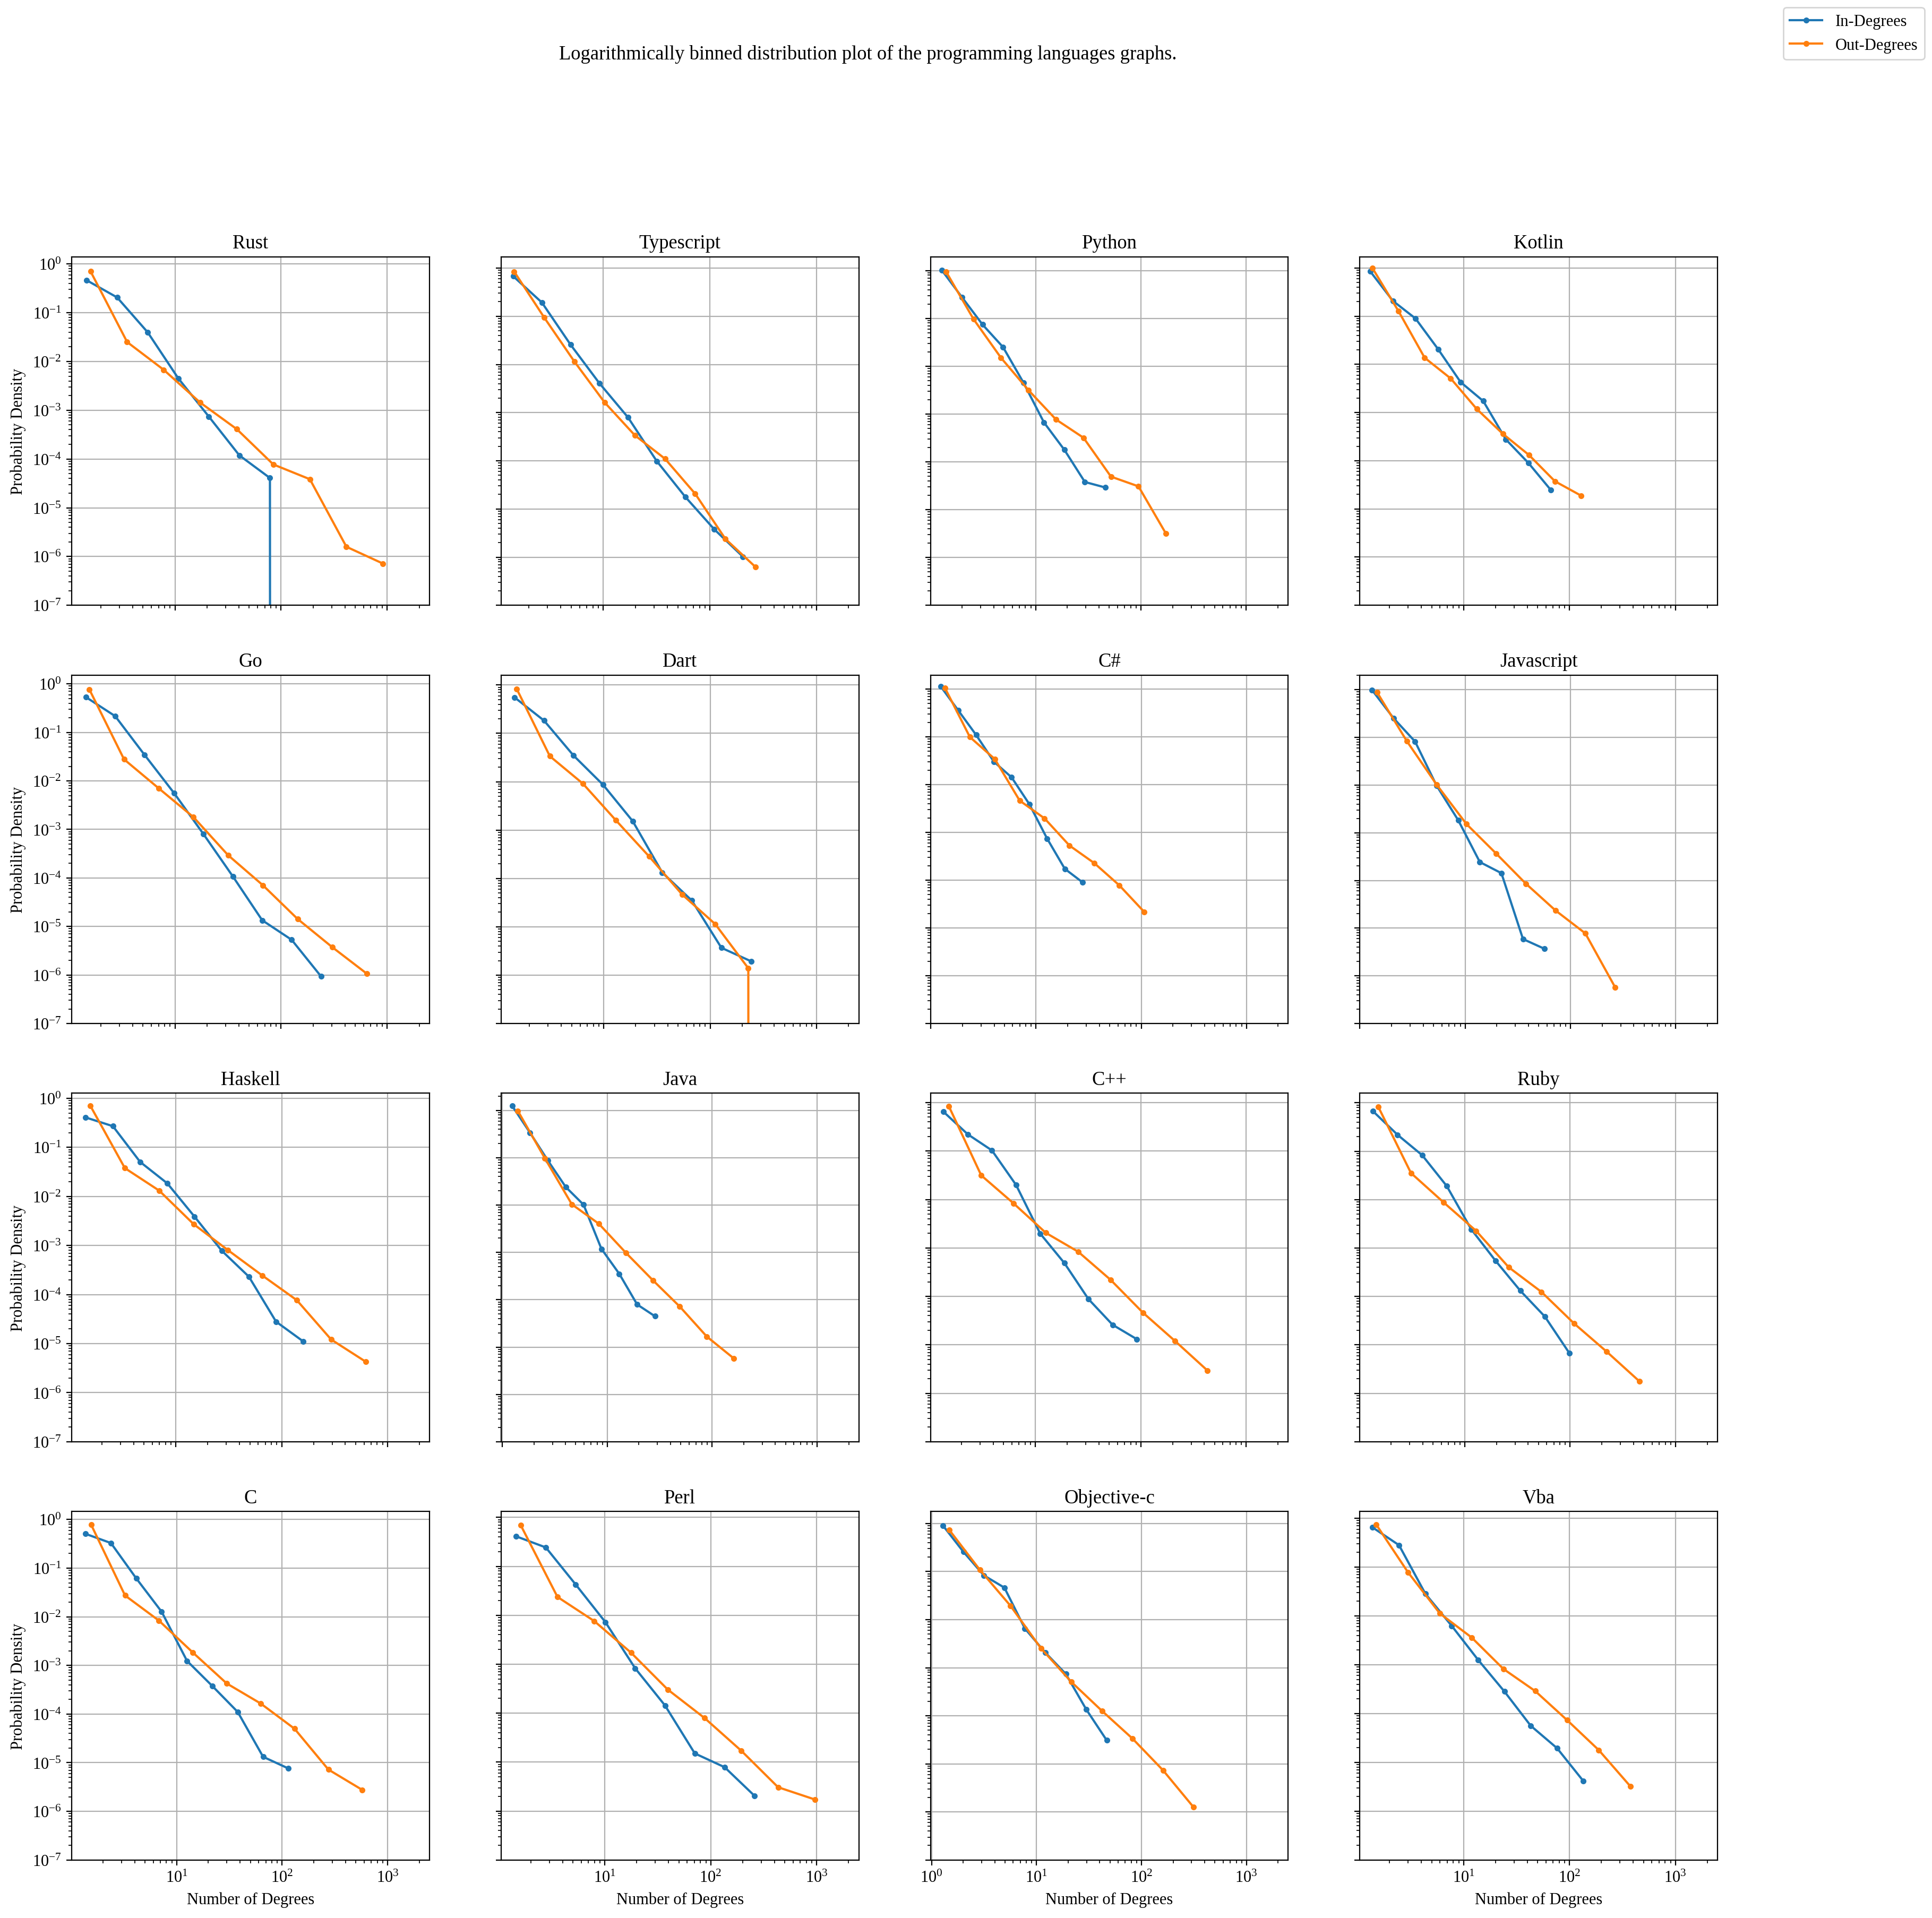

In [12]:
### This cell plots the in-out histograms for the single programming language networks

## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    
    return in_hist, x_in, out_hist, x_out

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (20,20)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plots
fig, axs = plt.subplots(4,4)
fig.suptitle('Logarithmically binned distribution plot of the programming languages graphs.')

for i in range(4):
    for j in range(4):
        prog_lang = list(graphs.keys())[i*4+j]
        # print(prog_lang)
        in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs[str(prog_lang)])
        
        axs[i,j].plot(x_in, in_hist, marker='.', label='In-Degrees')
        axs[i,j].plot(x_out, out_hist, marker='.', label='Out-Degrees')
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')
        axs[i,j].set_xlim([0, 2.5e3])
        axs[i,j].set_ylim([1e-7, 0])
        axs[i,j].set_title(f"{prog_lang.capitalize()}")
        axs[i,j].grid()

## Get labels on legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:2], labels[0:2])

for ax in axs.flat:
    ax.set(xlabel='Number of Degrees', ylabel='Probability Density')
    ax.label_outer()

plt.show()



In [25]:

import json
## Get plotting data as json for plotting on the webpage

if not os.path.exists('inoutdegreeplots/'):
    os.makedirs('inoutdegreeplots/')
    print("Created Directory: inoutdegreeplots/"),
else:
    print("Directory already existed: inoutdegreeplots/" )

for i in range(4):
    for j in range(4):
        prog_lang = list(graphs.keys())[i*4+j]
        in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs[str(prog_lang)])
        path = 'inoutdegreeplots/' + str(prog_lang) + '_inoutdegreehist.json'
        with open(path, "w") as f:
            json.dump({
                "in_hist": in_hist.tolist(),
                "x_in": x_in.tolist(),
                "out_hist": out_hist.tolist(),
                "x_out": x_out.tolist(),
            }, f)
in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['stack_overflow'])
path = 'inoutdegreeplots/' + 'so_graph' + '_inoutdegreehist.json'
with open(path, "w") as f:
    json.dump({
        "in_hist": in_hist.tolist(),
        "x_in": x_in.tolist(),
        "out_hist": out_hist.tolist(),
        "x_out": x_out.tolist(),
    }, f)

# in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['python'])
# # in_hist
# # x_in
# x_in.tolist()


    

Directory already existed: inoutdegreeplots/


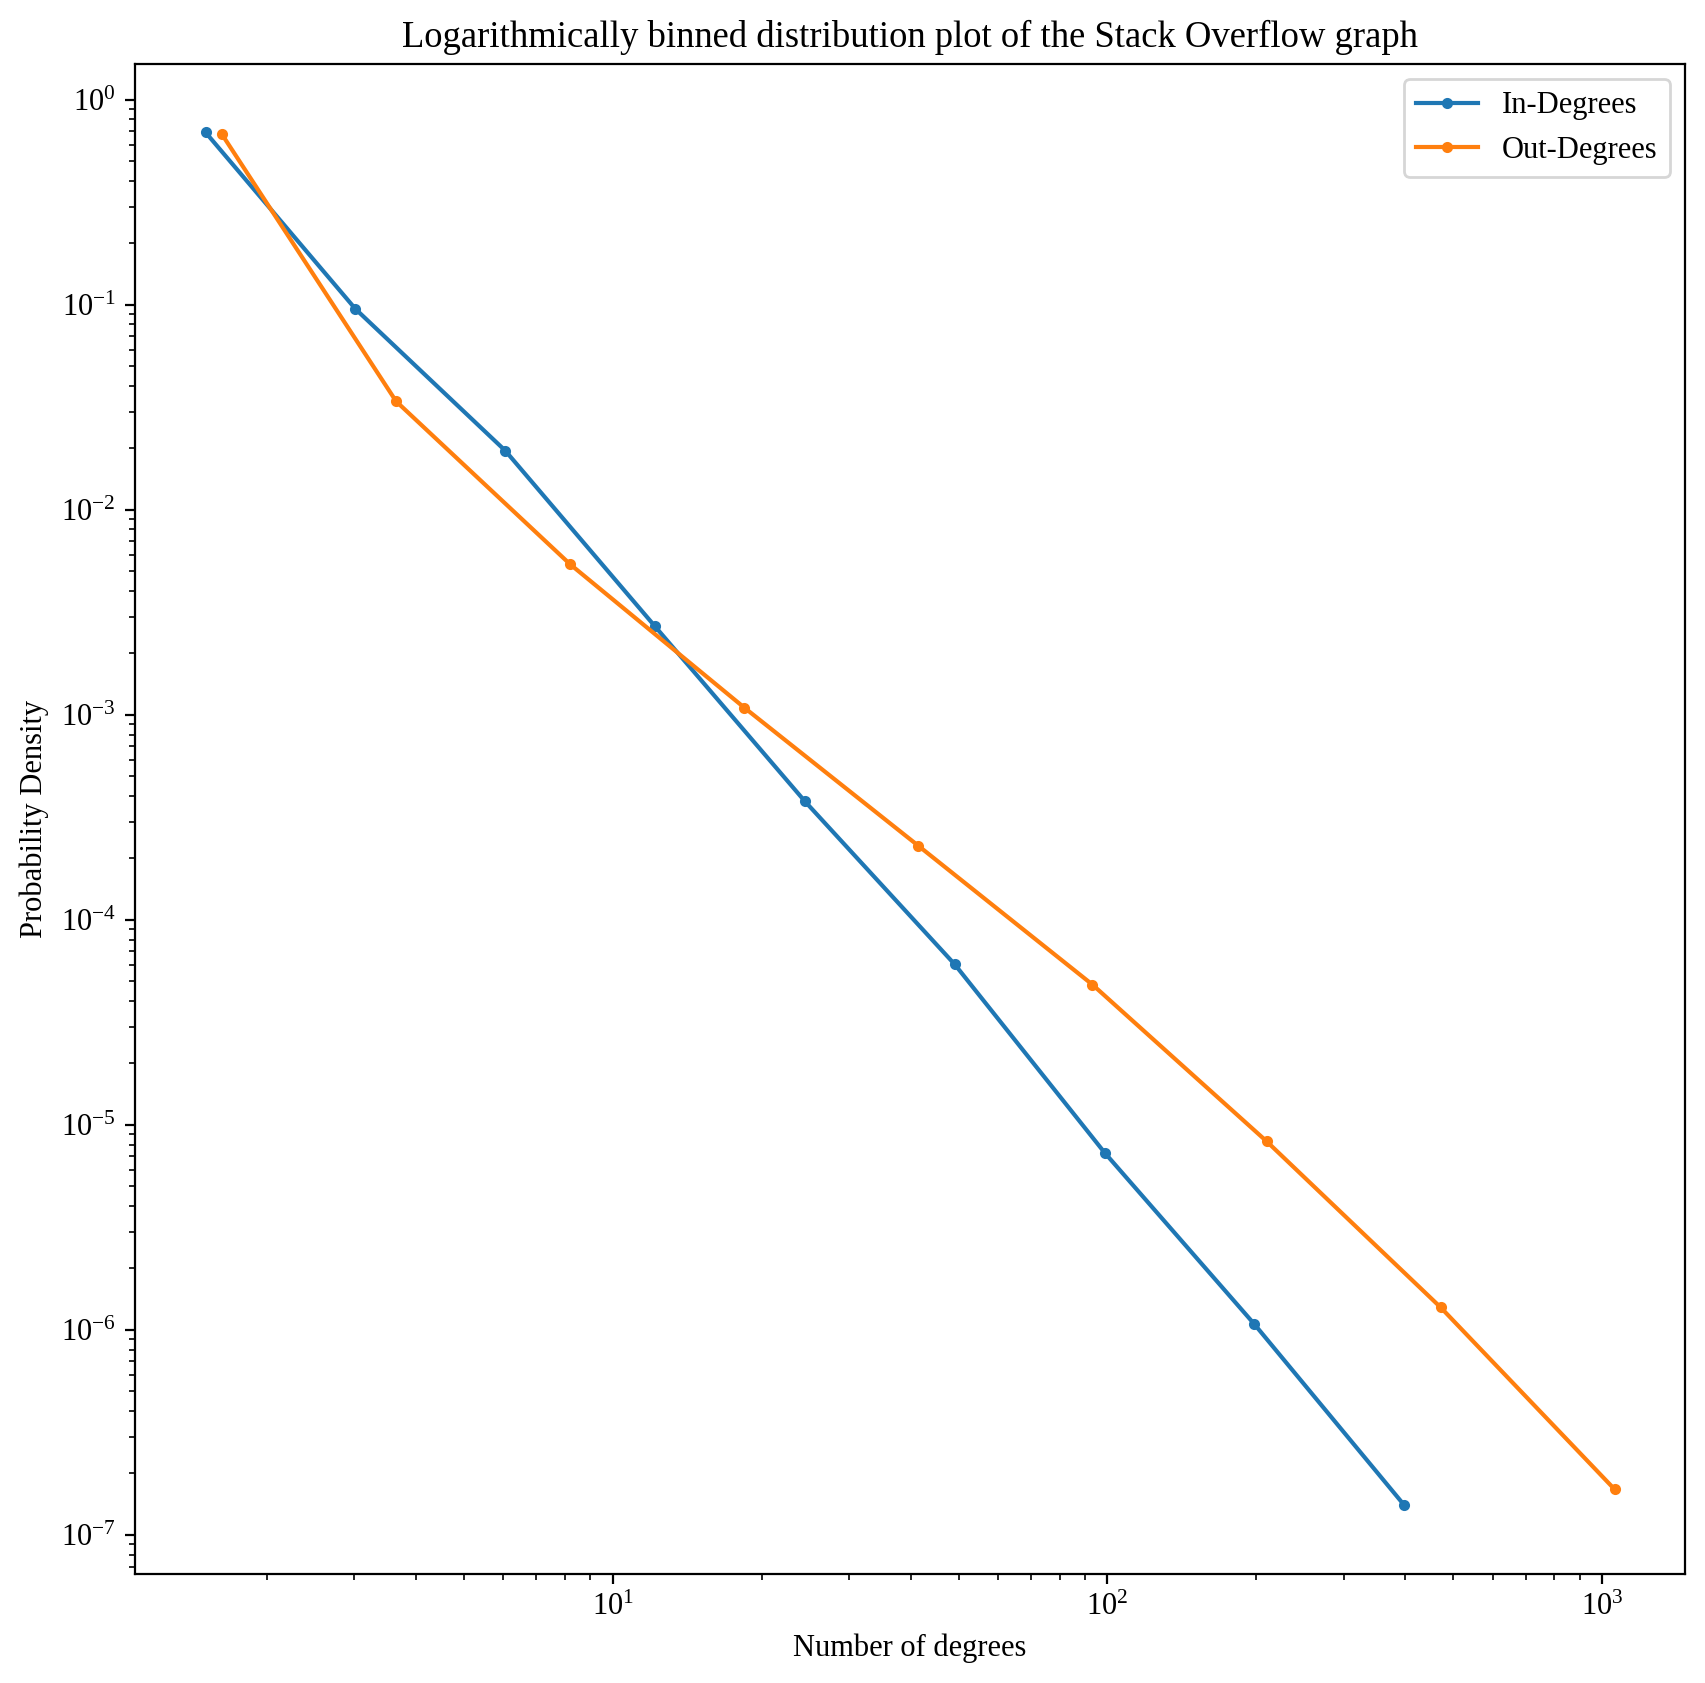

In [11]:
### This cell plots the in-out histogream for the big Stack Overflow network

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (10,10)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plot
fig, ax = plt.subplots()#, sharex=True)#, sharey=True)
# fig.suptitle('Logarithmically binned distribution plot of the Stack Overflow graphs.')

in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['stack_overflow'])

ax.plot(x_in, in_hist, marker='.', label='In-Degrees')
ax.plot(x_out, out_hist, marker='.', label='Out-Degrees')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([0, 2.5e3])
# ax.set_ylim([1e-7, 0])
ax.set_title('Stack Overflow')
ax.grid()

ax.set_xlabel('Number of degrees')
ax.set_ylabel('Probability Density')
ax.set_title(f"Logarithmically binned distribution plot of the Stack Overflow graph")
ax.grid()
ax.legend(loc='upper right')

plt.show()


# Comments for single programming language networks:
It is clear that the networks are similar for all of the programming languages, yet there are some outliers in terms of basic analysis metrics.
- First off, 

# Comments for big Stack Overflow network:

## 4. Vizualize the StackOverflow-network.

In [5]:
### In order to vizualise this very big network, we reduce it first
# so_graph_path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
so_graph_path ='so_graph.pkl'
reduced_so_graph = nx.read_gpickle(so_graph_path)

print('Before reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())
## First we remove all small island components which do not connect with the bigger network
for component in list(nx.weakly_connected_components(reduced_so_graph)):
    if len(component) < 500:
        for node in component:
            reduced_so_graph.remove_node(node)

## Then we remove all nodes with in-degree zero, ie. the outermost layer of nodes
# in_degree_zero = [node for node,degree in dict(reduced_so_graph.in_degree()).items() if degree == 0]
# reduced_so_graph.remove_nodes_from(in_degree_zero)

print('After reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())

Before reduction
222492
556901
After reduction
208962
546713


In [6]:
nf_config = {
    # Input/output
    'zoom': 0.6,
    # Physics
    'node_charge': -10,
    'node_gravity': 0.1,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 50,
    'node_stroke_width': 1,
    'node_size_variation': 0.24,
    # Links
    'link_color': '#ffffff',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1}

nf.visualize(reduced_so_graph, config=nf_config)

## 5. Compute the modularity of the Stack Overflow network, with erach partition consisting of authors with a given top programming language.

In [3]:
so_graph_path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
so_graph = nx.read_gpickle(so_graph_path)

so_undirected_graph_path = os.getcwd() + '/graphs/' + 'so_undirected_graph.pkl'
so_undirected_graph = nx.read_gpickle(so_undirected_graph_path)

In [8]:
print(so_graph.number_of_nodes())
print(so_undirected_graph.number_of_nodes())

print(so_graph.number_of_edges())
print(so_undirected_graph.number_of_edges())

198337
198337
351790
324471


In [10]:
### This cell is used for computing the modularity of the Stack Overflow Network

## Retrieve the 16 different programming languages as partitions
so_partitions = {prog_lang : [i for i in so_graph if so_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}
for prog_lang in loved_languages.keys():
    print(f"{len(so_partitions[prog_lang])} nodes belong to {prog_lang}")
print("")
## Retrieve the 16 different programming languages as partitions
so_undirected_partitions = {prog_lang : [i for i in so_undirected_graph if so_undirected_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}
for prog_lang in loved_languages.keys():
    print(f"{len(so_undirected_partitions[prog_lang])} nodes belong to {prog_lang}")

3979 nodes belong to rust
15115 nodes belong to typescript
17336 nodes belong to python
9209 nodes belong to kotlin
11054 nodes belong to go
6528 nodes belong to dart
17007 nodes belong to c#
18344 nodes belong to javascript
6099 nodes belong to haskell
17359 nodes belong to java
14757 nodes belong to c++
12744 nodes belong to ruby
15575 nodes belong to c
7960 nodes belong to perl
12537 nodes belong to objective-c
12734 nodes belong to vba

3979 nodes belong to rust
15115 nodes belong to typescript
17336 nodes belong to python
9209 nodes belong to kotlin
11054 nodes belong to go
6528 nodes belong to dart
17007 nodes belong to c#
18344 nodes belong to javascript
6099 nodes belong to haskell
17359 nodes belong to java
14757 nodes belong to c++
12744 nodes belong to ruby
15575 nodes belong to c
7960 nodes belong to perl
12537 nodes belong to objective-c
12734 nodes belong to vba


In [12]:
### The modularity of the Stack Overflow Graph

## Directed
so_modularity = nx.algorithms.community.modularity(G=so_graph, communities=so_partitions.values())
print("Modularity of Stack Overflow programming language splits: %.5f" % so_modularity)

## Undirected
so_undirected_modularity = nx.algorithms.community.modularity(G=so_undirected_graph, communities=so_undirected_partitions.values())
print("Modularity of Stack Overflow programming language splits: %.5f" % so_undirected_modularity)

Modularity of Stack Overflow programming language splits: 0.75416
Modularity of Stack Overflow programming language splits: 0.74499


## 6. Generate new, random versions of the Stack Overflow network by shuffling the target authors. Compute the average and std. of the modularity for these networks and compare to the found modularity.

In [9]:
### Compute random network similar to the Stack Overflow network
## Calculate network metrics
N = len(so_graph.nodes)
p = 2 * len(so_graph.edges) / (N * (N-1))  # Eq. 3.2
k_avg = p * (N-1)  # Eq. 3.3
print("p = %.6f\nk = %.6f" % (p, k_avg))

## Create random graph
random_graph = nx.erdos_renyi_graph(n=N, p=p, directed=True)
# random_graph = nx.fast_gnp_random_graph(n=N, p=p, directed=True)

# To make sure that N and p are correctly calculated, g should have the same number of nodes as ug and roughly the same number of edges
t = Table()
t.add_header(["Comparison of random and Stack Overflow graph", "Nodes", "Edges"])
t.add_row(["Random graph", len(random_graph.nodes), len(random_graph.edges)])
t.add_row(["Redditor graph", len(so_graph.nodes), len(so_graph.edges)])
print(t)

path = os.getcwd() + '/graphs/' + 'random_graph.pkl'
nx.write_gpickle(random_graph, path)

p = 0.000018
k = 3.547397
Comparison of random and Stack Overflow graph | Nodes  | Edges 
----------------------------------------------+--------+-------
Random graph                                  | 198337 | 701898
Redditor graph                                | 198337 | 351790


In [23]:
### We create randomized versions of the Stack Overflow Graph
def conf_model(graph):
    
    ## Create graph that is a copy of nodes
    g = nx.DiGraph()
    g.add_nodes_from(graph.nodes)
    # g.add_edges_from(graph.edges)
    
    ## Shuffle edge targets and add edges
    sources, targets = np.transpose(graph.edges)
    np.random.shuffle(targets)
    edges = [(source, target) for source, target in np.transpose([sources, targets])]
    # g.remove_edges_from(graph.edges)
    g.add_edges_from(edges)

    return g

In [22]:
modularity(graph=conf_model(so_graph), partitions=partitions.values())

-0.00048412671712697595

In [25]:
random_modularities = [modularity(graph=conf_model(so_graph), partitions=partitions.values()) for _ in tqdm(range(10))]


100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


In [27]:
print("Average modularity: %.10f" % np.mean(random_modularities))
print("Standard deviation: %.10f" % np.std(random_modularities, ddof=1))

Average modularity: 0.0000437893
Standard deviation: 0.0004619424


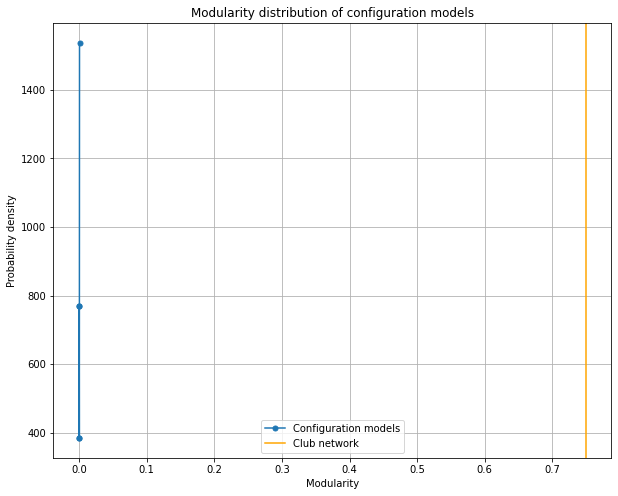

In [32]:
## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    
    return in_hist, x_in, out_hist, x_out


def bins(data, spacing=lambda x, b: np.linspace(0, max(x), b), bins=10):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy
    
## Use binning function from Part 1
mod, dens = bins(random_modularities, lambda x, b: np.linspace(min(x), max(x), b), bins=5)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(mod, dens, marker=".", ms=10, label="Configuration models")
ax.axvline(modularity(graph=so_graph, partitions=partitions.values()), c="orange", label="Club network")
ax.grid(True)
ax.set_title("Modularity distribution of configuration models")
ax.set_xlabel("Modularity")
ax.set_ylabel("Probability density")
ax.legend()

## 6. Use the Louvain algorithm to create a network from the data and compare to the StackOverflow-network.


In [13]:


partition = cm.best_partition(so_undirected_graph)
nc = max(partition.values()) + 1
ns = [[] for i in range(nc)]
for i, p in partition.items():
    ns[p].append(i)
print("Modularity according to Louvain algorithm: %.4f" % nx.algorithms.community.modularity(G=so_undirected_graph, communities=ns))
print("Number of partitions: %i" % nc)

Modularity according to Louvain algorithm: 0.7989
Number of partitions: 11551


0.7989085767836578

# Extra..

In [ ]:
# ### Average shortest path for the largest connected component of the Stack Overflow network
# blocks = nx.algorithms.connected_components(so_graph)
# largest_block = set()
# m = 0
# # Compute largest connected component
# for b2lock in tqdm(blocks):
#     if len(block) < m:
#         continue
#     m = len(block)
#     largest_block = block

# # Get subgraph/giant component
# so_graph_sg = nx.Graph.subgraph(so_graph, largest_block)
# print("Number of nodes in largest connected component of the Stack Overflow network: %i" % len(so_graph_sg))

# ### Average shortest path length of the giant component
# avg_shortest_path = nx.average_shortest_path_length(so_graph_sg)
# print("Average shortest path: %.4f" % avg_shortest_path)

# ### The clustering coefficient for all nodes in the Stack Overflow Graph
# cluster_coefs = nx.algorithms.cluster.clustering(so_graph)
# avg_cluster_coef = sum(cluster_coefs.values()) / len(cluster_coefs)
# print("Average clustering coefficient in Stack Overflow network: %.6f" % avg_cluster_coef)